# Import packages

In [56]:
import pandas  as pd # Data manipulation
import numpy as np #Data manipulation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
# from scipy.stats import boxcox

# plt.rcParams['figure.figsize'] = [12,5]
# plt.rcParams['font.size'] =9
# plt.rcParams['font.weight']= 'bold'
# plt.style.use('seaborn-v0_8-whitegrid')

# Import data

In [59]:
df = load_data("Boston")
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7


# Explore data

In [ ]:
# Check nulls
df.info()

In [ ]:
df.describe()

### Corrolation

In [ ]:
# We identify categorical variables as well as multicolinearity between independant variables
sns.pairplot(df)

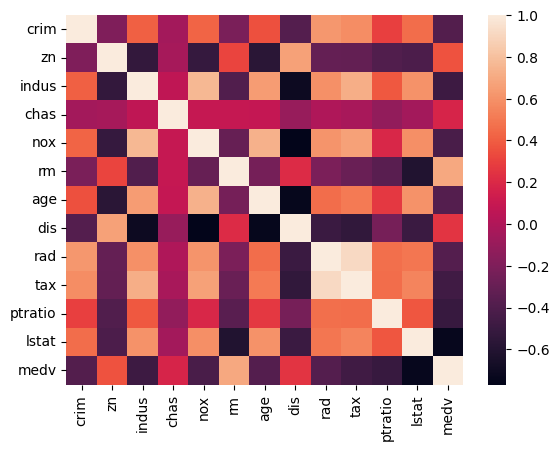

In [3]:
# See corrolation as a heatmap
corr = df.corr()
sns.heatmap(corr);

In [41]:
abs(df.corr()['medv']).sort_values()

chas       0.175260
dis        0.249929
zn         0.360445
age        0.376955
rad        0.381626
crim       0.388305
nox        0.427321
tax        0.468536
indus      0.483725
ptratio    0.507787
rm         0.695360
lstat      0.737663
medv       1.000000
Name: medv, dtype: float64

# Data pre-processing

### Drop columns based on corrolation/colinearity

In [60]:
# df_processed = df.drop(columns=['dis', 'tax'])
# df_processed = df.copy()

df_processed = df[['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'medv']]

In [63]:
MS(['lstat', 'rm', 'ptratio', 'indus', 'tax', 'nox', 'medv']).fit_transform(df)

,intercept,lstat,rm,ptratio,indus,tax,nox,medv
0,1.0,4.98,6.575,15.3,2.31,296,0.538,24.0
1,1.0,9.14,6.421,17.8,7.07,242,0.469,21.6
2,1.0,4.03,7.185,17.8,7.07,242,0.469,34.7
3,1.0,2.94,6.998,18.7,2.18,222,0.458,33.4
4,1.0,5.33,7.147,18.7,2.18,222,0.458,36.2
...,...,...,...,...,...,...,...,...
501,1.0,9.67,6.593,21.0,11.93,273,0.573,22.4
502,1.0,9.08,6.120,21.0,11.93,273,0.573,20.6
503,1.0,5.64,6.976,21.0,11.93,273,0.573,23.9
504,1.0,6.48,6.794,21.0,11.93,273,0.573,22.0


### Create interaction terms

In [62]:
MS(['lstat',
'age',
('lstat', 'age')]).fit_transform(df)

,intercept,lstat,age,lstat:age
0,1.0,4.98,65.2,324.696
1,1.0,9.14,78.9,721.146
2,1.0,4.03,61.1,246.233
3,1.0,2.94,45.8,134.652
4,1.0,5.33,54.2,288.886
...,...,...,...,...
501,1.0,9.67,69.1,668.197
502,1.0,9.08,76.7,696.436
503,1.0,5.64,91.0,513.240
504,1.0,6.48,89.3,578.664


### One-hot encoding

In [44]:
# Dummy variable
categorical_columns = []
df_processed = pd.get_dummies(data = df_processed, #prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')
df_processed.head(3)

,lstat,rm,ptratio,indus,tax,nox,medv
0,4.98,6.575,15.3,2.31,296,0.538,24.0
1,9.14,6.421,17.8,7.07,242,0.469,21.6
2,4.03,7.185,17.8,7.07,242,0.469,34.7


### Remove outliers if they significantly affect regression performance

# Feature scaling

### Log transformation

In [45]:
df_processed_scaled = df_processed.copy()

# List of columns to transform
columns_to_transform = ['lstat', 'ptratio']

# Apply log transformation (using np.log1p to avoid log(0) issues)
df_processed_scaled[columns_to_transform] = np.log(df_processed_scaled[columns_to_transform])

# sns.pairplot(df_processed_scaled)

In [ ]:
# df_processed_scaled = df_processed

### Min-max scaling (if necessary)

# Build the model

### Split data into training and testing sets

In [46]:
# Columns to drop based on p-value
columns_to_drop = ['tax']

# Separate dependent variable
X = df_processed_scaled.drop('medv',axis=1) # Independet variable
y = df_processed_scaled['medv'] # dependent variable

# Drop columns based on p-value
X = X.drop(columns=columns_to_drop)
y= y.drop(columns=columns_to_drop)

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=23)

### Fit the model

In [47]:
# sklearn model
model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train); # x_0 =1 is no need to add, sklearn will take care of it.

# Make Predictions
y_pred = model_sklearn.predict(X_test)

# OLS model
model_OLS = sm.OLS(y_train, X_train)
results = model_OLS.fit()
print('Intercept:',model_sklearn.intercept_)
summarize(results)


Intercept: 63.60642352753179


,coef,std err,t,P>|t|
lstat,-8.6428,0.691,-12.505,0.000
rm,5.3674,0.440,12.194,0.000
ptratio,2.2338,1.259,1.775,0.077
indus,-0.0488,0.063,-0.778,0.437
nox,6.1488,3.667,1.677,0.094


# Assess the Model

### Is there a relationship between the response and predictors? (F-statistic)

### How well does the model fit the data? (MSE, R², and Adjusted R²)

In [48]:
# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 23.18
R² Score: 0.72


In [ ]:
Mean Squared Error (MSE): 19.12
R² Score: 0.77


# Check Model Assumptions

### Linearity (Residuals plot)

### Multicollinearity: Identify high correlations using VIF (Variance Inflation Factor).

### Homoscedasticity: Residuals should have constant variance (plot residuals vs. predicted values).

### Heteroscedasticity

### Normality of Residuals: Residuals should be approximately normally distributed (QQ plot, Shapiro-Wilk test

# Interpret the Results